In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/code/CS224N
! pwd
! ls data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/code/CS224N
/content/drive/My Drive/code/CS224N
mydata.csv  mydata.pkl	SCBAll.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

!pip install transformers
!pip install sentencepiece
!pip install wandb -q

import torch
from transformers import AutoModelWithLMHead, AutoTokenizer
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
from transformers import AdamW

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_reserved(0)/1e6

0.0

In [ ]:
torch.cuda.memory_allocated(0)/1e6

0.0

In [ ]:
torch.cuda.memory_reserved(0)/1e6, torch.cuda.memory_allocated(0)/1e6

(983.564288, 891.614208)

In [ ]:
torch.cuda.get_device_properties(0).total_memory/1e9

17.071734784

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tuner007/t5_abs_qa")
model_original = AutoModelWithLMHead.from_pretrained("tuner007/t5_abs_qa")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:882: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [ ]:
model = model_original.to(device)
def get_answer(question, context): ### check
  input_text = "context: %s <question for context: %s </s>" % (context,question)
  features = tokenizer([input_text], return_tensors='pt')
  out = model.generate(input_ids=features['input_ids'].to(device), attention_mask=features['attention_mask'].to(device))
  print(out[0])
  # for i in out[0]:
  #   print(i,tokenizer.decode(i))
  return tokenizer.decode(out[0]) ### test if we dont store the output

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [ ]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

## quick demo

In [ ]:
%%capture
### to suppress output
model.eval()

In [ ]:
tokenizer(['<pad> It is a hall of worship ruled by Odin.</s>'])

{'input_ids': [[0, 94, 19, 3, 9, 6358, 13, 7373, 3, 16718, 57, 9899, 77, 5, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
context = "In Norse mythology, Valhalla is a majestic, enormous hall located in Asgard, ruled over by the god Odin."
question = "What is Valhalla?"
get_answer(question, context)
# output: 'It is a hall of worship ruled by Odin.'

tensor([    0,    94,    19,     3,     9,  6358,    13,  7373,     3, 16718,
           57,  9899,    77,     5,     1], device='cuda:0')


'<pad> It is a hall of worship ruled by Odin.</s>'

## eval without finetuning

In [ ]:
df = pd.read_csv('data/mydata.csv')

In [ ]:
df['old QA'] = df['answer'].copy()

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
#  len(df['article'].iloc[193])

In [ ]:
# for i in range(len(df)):
for i in range(10):
    if i%100==0 or i<10:
        print(i)
    try:
        df['old QA'].iloc[i] = get_answer(df['teaser'].iloc[i], df['article'].iloc[i])
    except RuntimeError as e:
        print(e)
        df['old QA'].iloc[i] = 'Too long, GPU memory exceeded'
    if i%10 ==0:
        df.to_csv('mydata2.csv')
    # torch.cuda.empty_cache()

0
tensor([   0,  465, 1525,  347,   16, 2625,    1], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1
tensor([   0,  328,  435,    3,    9,  126, 1876, 1096,   70, 1683,  915,    5,
           1], device='cuda:0')
2
tensor([   0,  451,  133,  281,   12,  217,  160, 7370,   11,  129,  160, 1268,
        1340,    5,    1], device='cuda:0')
3
tensor([    0,    37, 11511,   789,    65, 18094,    15,    26,   529,    18,
         8185, 10646,  1623,     5,     1], device='cuda:0')
4
tensor([   0,  328,   33,   59,   30, 1641,  544,    5,    1], device='cuda:0')
5
tensor([   0,  465, 1525,  347,   16, 2625,    1], device='cuda:0')
6
tensor([   0,  465, 1525,  347,   16, 2625,    1], device='cuda:0')
7
tensor([   0,   37, 4836,    1], device='cuda:0')
8
tensor([   0,  465, 1525,  347,   16, 2625,    1], device='cuda:0')
9
tensor([   0,   27,  183,    3,    9,  306,  496, 9999, 3763,    5,    1],
       device='cuda:0')


In [ ]:
# df.to_csv('mydata1.csv')

In [ ]:
# print(df.iloc[50]['article'])
print(df.iloc[50]['teaser'])
print(df.iloc[50]['answer'])
print(df.iloc[50]['old QA'])

Why did 'Pawn Star' Richard "The Olde Man" Harrison intentionally disinherit his youngest son Christopher, cutting him from any inheritance a few months before dying?
You never find out. After scrolling longer than a CVS receipt you learn it's a private family matter they aren't talking about.
You never find out. After scrolling longer than a CVS receipt you learn it's a private family matter they aren't talking about.


## finetune further

In [ ]:
optim = AdamW(model.parameters(), lr=5.0e-5)
train_test_split = 2000 ### leaving 300+ for test
N_epochs = 8

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
torch.cuda.memory_reserved(0)/1e6, torch.cuda.memory_allocated(0)/1e6

(989.855744, 891.614208)

In [ ]:
%%capture
### to suppress output
model.train()

In [ ]:
context = "In Norse mythology, Valhalla is a majestic, enormous hall located in Asgard, ruled over by the god Odin."
question = "What is Valhalla?"
input_text = "context: %s <question for context: %s </s>" % (context,question)
features = tokenizer([input_text], return_tensors='pt')
# targets = tokenizer(['<pad> It is a hall of worship ruled by Odin.</s>'], return_tensors='pt')['input_ids'].to(device)
targets = tokenizer(['<pad> It is a Dummy Answer.</s>'], return_tensors='pt')['input_ids'].to(device)

In [ ]:
train_test_split

2000

below is some debugging effort to figure out why we run out of GPU memory after finetuning. The current best guess is that after the model encounter super long text and crashes due to running out of memory, it fails to clear all allocated memory. So the workaround is to prune the data and avoid trainig on too long texts.

In [ ]:
df['article'].iloc[2]

'Is there anything more important than a birthday to a kid? All year long, they wait and wait for their special day where everyone celebrates them and showers them with gifts, excited to finally be a year older. Some kids have parents that have separated – but hey, it’s a reason to celebrate twice! Kelsey Frederick is one such teenager with two divorced parents who both still love her very much. Her parents Christin and Schaffen seemed to have no problem coordinating two separate parties to spend with Kelsey. But when her birthday came around, it turned out they had very different plans in mind. Unhappy Birthday To You Kelsey Frederick recently turned 13, and even had two birthday parties to look forward to in order to celebrate with each of her parents. It was a routine the whole family had grown accustomed to over the years. But this year, she was extra excited because her mom had decided to treat her to highlights in her hair for the very first time! Afterward, she went on to see he

In [ ]:
# len(df['article'].iloc[i].split(' '))
' '.join(df['article'].iloc[i].split(' ')[:1000])

2846

In [ ]:
lens = []
for i in range(len(df)):
  lens.append(len(df['article'].iloc[i].split(' ')))
  # lens.append(len(df['article'].iloc[i]))
  # if len(df['article'].iloc[i])==100000:
  #   # print(df[['title','article']].iloc[i])
  #   print(df['answer'].iloc[i])
  #   print(df['article'].iloc[i])
# print(max(lens))

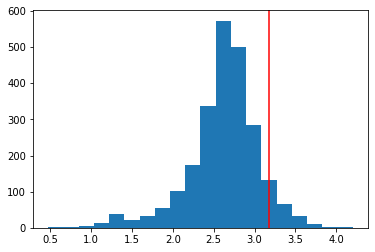

In [ ]:
plt.hist(np.log10(lens),bins=20)
plt.axvline(x=np.log10(1500),color='red')

In [ ]:
# for i in range(200):
i=2
# if i%10==0:
#   print(i)
# context = df['article'].iloc[i]
context = ' '.join(df['article'].iloc[i].split(' ')[:1500])
question = df['teaser'].iloc[i]
input_text = "context: %s <question for context: %s </s>" % (context,question)
features = tokenizer([input_text], return_tensors='pt')
targets = tokenizer(['<pad> '+ df['answer'].iloc[i] +'</s>'], return_tensors='pt')['input_ids'].to(device) ### check
targets_in = targets[:,:-1].contiguous()
targets_out = targets[:,1:].clone().detach() ### check
targets_out[targets[:,1:] == tokenizer.pad_token_id] = -100
try:
  outputs = model(input_ids=features['input_ids'].to(device), attention_mask=features['attention_mask'].to(device), decoder_input_ids=targets_in, labels = targets_out)
  loss = outputs[0]
  loss.backward()
  optim.step()
except Exception as e:
  print(e)
  # continue
  pass


In [ ]:
torch.cuda.memory_reserved(0)/1e6, torch.cuda.memory_allocated(0)/1e6

(15556.673536, 3690.210304)

In [ ]:
del features, targets, targets_out, targets_in, outputs, loss

In [ ]:
with torch.no_grad():
  print(torch.cuda.memory_reserved(0)/1e6, torch.cuda.memory_allocated(0)/1e6)

13895.729152 11454.027776


In [ ]:
# del optim
# del model
# torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()
# model.eval()

End of debugging effort

In [ ]:
for epoch in range(N_epochs):
  print('Epoch',epoch)
  for i in tqdm(range(train_test_split)):
    context = df['article'].iloc[i]
    question = df['teaser'].iloc[i]
    input_text = "context: %s <question for context: %s </s>" % (context,question)
    features = tokenizer([input_text], return_tensors='pt')
    targets = tokenizer(['<pad> '+ df['answer'].iloc[i] +'</s>'], return_tensors='pt')['input_ids'].to(device) ### check
    targets_in = targets[:,:-1].contiguous()
    targets_out = targets[:,1:].clone().detach() ### check
    targets_out[targets[:,1:] == tokenizer.pad_token_id] = -100
    try:
      outputs = model(input_ids=features['input_ids'].to(device), attention_mask=features['attention_mask'].to(device), decoder_input_ids=targets_in, labels = targets_out)
      loss = outputs[0]
      loss.backward()
      optim.step()
    except:
      continue
    

Epoch 0


100%|██████████| 2000/2000 [00:40<00:00, 49.17it/s]


Epoch 1


100%|██████████| 2000/2000 [00:39<00:00, 51.07it/s]


Epoch 2


100%|██████████| 2000/2000 [00:39<00:00, 50.02it/s]


Epoch 3


100%|██████████| 2000/2000 [00:39<00:00, 50.45it/s]


Epoch 4


100%|██████████| 2000/2000 [00:39<00:00, 50.04it/s]


Epoch 5


100%|██████████| 2000/2000 [00:39<00:00, 50.99it/s]


Epoch 6


100%|██████████| 2000/2000 [00:39<00:00, 51.05it/s]


Epoch 7


100%|██████████| 2000/2000 [00:38<00:00, 51.39it/s]


In [ ]:
%%capture
### to suppress output
model.eval()

In [ ]:
df['after 10 epochs'] = df['answer'].copy()
for i in tqdm(range(len(df))):
    try:
        df['after 10 epochs'].iloc[i] = get_answer(df['teaser'].iloc[i], df['article'].iloc[i])
    except RuntimeError as e:
        # print(e)
        df['after 10 epochs'].iloc[i] = 'Too long, GPU memory exceeded'
    if i%10 ==0:
        df.to_csv('mydata_10epochs.csv')
    # torch.cuda.empty_cache()
df.to_csv('mydata_10epochs.csv')

  0%|          | 0/2385 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 2385/2385 [02:20<00:00, 16.99it/s]


In [ ]:
# df['after 2 epochs'] = df['answer'].copy()
# for i in tqdm(range(len(df))):
#     try:
#         df['after 2 epochs'].iloc[i] = get_answer(df['teaser'].iloc[i], df['article'].iloc[i])
#     except RuntimeError as e:
#         # print(e)
#         df['after 2 epochs'].iloc[i] = 'Too long, GPU memory exceeded'
#     if i%10 ==0:
#         df.to_csv('mydata_2epochs.csv')
#     # torch.cuda.empty_cache()
# df.to_csv('mydata_2epochs.csv')

  0%|          | 0/2385 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 2385/2385 [07:27<00:00,  5.33it/s]


In [ ]:
df['after 2 epochs'].iloc[20]

'<pad> Taylor Swift is a fan of the folklore album.</s>'

In [ ]:
df['after 2 epochs'].equals(df['old QA'])

False

In [ ]:
df.loc[df['after 2 epochs'] != df['old QA']][['after 2 epochs','old QA']]

,after 2 epochs,old QA
2,"Too long, GPU memory exceeded",<pad> She would go to see her dad and get her ...
12,"Too long, GPU memory exceeded",<pad> He was able to help Andrella with her ca...
14,"Too long, GPU memory exceeded",<pad> She was a size 8 and had a large ovary.</s>
16,"Too long, GPU memory exceeded",<pad> She was unable to find the information s...
19,<pad> They are becoming a standard in other ci...,<pad> The city is considering a plan to make t...
...,...,...
2332,<pad> No answer available in context</s>,<pad> Apple is rumored to be replacing the 30-...
2335,<pad> The final season of the series is set fo...,<pad> The final season of the series will debu...
2364,<pad> The show will return to Netflix in 2021....,<pad> The show will be set in a different loca...
2366,<pad> No answer available in context</s>,<pad> Moderna or Pfizer booster shots are the ...


In [ ]:
df.loc[df['after 2 epochs'] != df['old QA']][['after 2 epochs','old QA']]

NameError: ignored

In [ ]:
df = pd.read_csv('mydata_10epochs.csv')

In [ ]:
df.loc[df['after 2 epochs'] != df['old QA']][['answer','old QA','after 2 epochs','after 10 epochs']]

,answer,old QA,after 2 epochs,after 10 epochs
2,"Makes a viral social media post, wins full cus...",<pad> She would go to see her dad and get her ...,"Too long, GPU memory exceeded","Too long, GPU memory exceeded"
12,She had three kids in the back that weren't bu...,<pad> He was able to help Andrella with her ca...,"Too long, GPU memory exceeded","Too long, GPU memory exceeded"
14,"It's a 60lbs ovarian cyst, no cops are called ...",<pad> She was a size 8 and had a large ovary.</s>,"Too long, GPU memory exceeded","Too long, GPU memory exceeded"
16,Husband with secret second family. Except it w...,<pad> She was unable to find the information s...,"Too long, GPU memory exceeded","Too long, GPU memory exceeded"
19,Cyclists don't like being run over by cars.,<pad> The city is considering a plan to make t...,<pad> They are becoming a standard in other ci...,"Too long, GPU memory exceeded"
...,...,...,...,...
2332,Might replace lightning connector with USB-C,<pad> Apple is rumored to be replacing the 30-...,<pad> No answer available in context</s>,"Too long, GPU memory exceeded"
2335,Debut is April 14,<pad> The final season of the series will debu...,<pad> The final season of the series is set fo...,"Too long, GPU memory exceeded"
2364,[Season 3 will return sometime in 2021. Joe wi...,<pad> The show will be set in a different loca...,<pad> The show will return to Netflix in 2021....,"Too long, GPU memory exceeded"
2366,"Pfizer , Moderna , J&J",<pad> Moderna or Pfizer booster shots are the ...,<pad> No answer available in context</s>,"Too long, GPU memory exceeded"
